## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.regularizers import l1, l2, l1_l2

"""Code Here
建立你的神經網路
"""

def build_mlp_BN(input_shape, output_units=10, num_neurons=[512, 256, 128],regularizers = l1, ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


def build_mlp_DP(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2, regularizers = l1, ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95
Dropout_EXP = 0.25
regularizers = [l1 , l1_l2 , l2]
ratio = [1e-4, 1e-8]

## BatchNorm with Different Regulizers

In [12]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regularizer in regularizers:
    for regulizer_ratio in ratio:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Using regularizer: ", regularizer, ", Experiment BatchNorm with Regulizer = %.6f" % (regulizer_ratio))
        model = build_mlp_BN(input_shape=x_train.shape[1:], regularizers = regularizer, ratio=regulizer_ratio)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)
    
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
    
        exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Using regularizer:  <function l1 at 0x000002B3825ACB70> , Experiment BatchNorm with Regulizer = 0.000100
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (N

50000/50000 [==============================] - 9s 177us/step - loss: 1.3687 - acc: 0.5217 - val_loss: 1.5084 - val_acc: 0.4721
Epoch 9/25
50000/50000 [==============================] - 9s 175us/step - loss: 1.3390 - acc: 0.5326 - val_loss: 1.5057 - val_acc: 0.4726
Epoch 10/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.3090 - acc: 0.5448 - val_loss: 1.4901 - val_acc: 0.4766
Epoch 11/25
50000/50000 [==============================] - 9s 189us/step - loss: 1.2827 - acc: 0.5540 - val_loss: 1.4841 - val_acc: 0.4815
Epoch 12/25
50000/50000 [==============================] - 9s 178us/step - loss: 1.2571 - acc: 0.5614 - val_loss: 1.4875 - val_acc: 0.4785
Epoch 13/25
50000/50000 [==============================] - 8s 170us/step - loss: 1.2321 - acc: 0.5741 - val_loss: 1.4730 - val_acc: 0.4880
Epoch 14/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.2069 - acc: 0.5824 - val_loss: 1.4647 - val_acc: 0.4877
Epoch 15/25
50000/50000 [===============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 166us/step - loss: 2.2386 - acc: 0.2694 - val_loss: 2.1165 - val_acc: 0.3216
Epoch 2/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.7589 - acc: 0.3840 - val_loss: 1.8144 - val_acc: 0.3845
Epoch 3/25
50000/50000 [==============================] - 11s 229us/step - loss: 1.6280 - acc: 0.4283 - val_loss: 1.6848 - val_acc: 0.4194
Epoch 4/25
50000/50000 [==============================] - 14s 272us/step - loss: 1.5525 - acc: 0.4542 - val_loss: 1.6305 - val_acc: 0.4343
Epoch 5/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.4982 - acc: 0.4743 - val_loss: 1.5952 - val_acc: 0.4420
Epoch 6/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.4526 - acc: 0.4899 - val_loss: 1.5734 - val_acc: 0.4508
Epoch 7/25
50000/50000 [==============================] - 12s 238us/step - loss: 1.4129 - acc: 0.5061 - val_loss: 1.5444

50000/50000 [==============================] - 8s 157us/step - loss: 1.0037 - acc: 0.6594 - val_loss: 1.4600 - val_acc: 0.4954
Epoch 24/25
50000/50000 [==============================] - 8s 158us/step - loss: 0.9816 - acc: 0.6679 - val_loss: 1.4769 - val_acc: 0.4913
Epoch 25/25
50000/50000 [==============================] - 8s 157us/step - loss: 0.9605 - acc: 0.6753 - val_loss: 1.4716 - val_acc: 0.4938
Using regularizer:  <function l2 at 0x000002B3825ACF28> , Experiment BatchNorm with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
____________________________

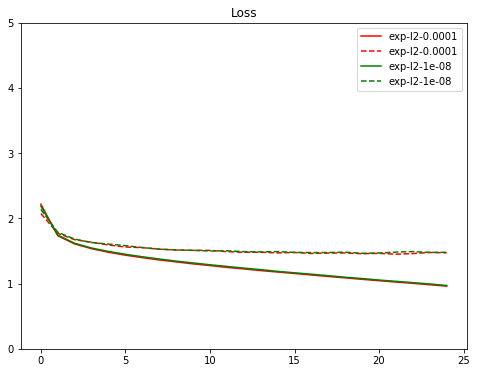

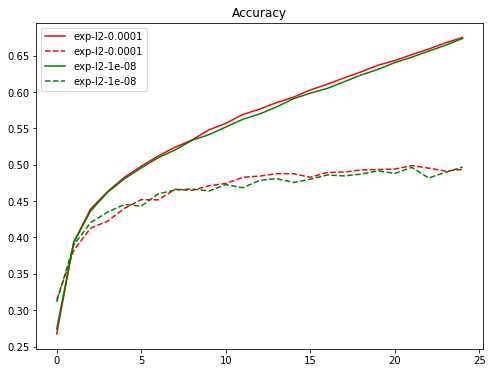

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## Dropout with different Regulizers

In [14]:
results_1 = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regularizer in regularizers:
    for regulizer_ratio in ratio:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Using regularizer: ", regularizer, ", Experiment BatchNorm with Regulizer = %.6f" % (regulizer_ratio))
        model = build_mlp_DP(input_shape=x_train.shape[1:], regularizers = regularizer, ratio=regulizer_ratio)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)
    
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
    
        exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
        results_1[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Using regularizer:  <function l1 at 0x000002B3825ACB70> , Experiment BatchNorm with Regulizer = 0.000100
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
______________________________________________________

50000/50000 [==============================] - 7s 148us/step - loss: 1.8604 - acc: 0.3303 - val_loss: 1.7869 - val_acc: 0.3706
Epoch 11/25
50000/50000 [==============================] - 7s 150us/step - loss: 1.8452 - acc: 0.3351 - val_loss: 1.7704 - val_acc: 0.3766
Epoch 12/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.8306 - acc: 0.3426 - val_loss: 1.7552 - val_acc: 0.3807
Epoch 13/25
50000/50000 [==============================] - 8s 150us/step - loss: 1.8178 - acc: 0.3486 - val_loss: 1.7407 - val_acc: 0.3865
Epoch 14/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.8032 - acc: 0.3531 - val_loss: 1.7257 - val_acc: 0.3884
Epoch 15/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.7919 - acc: 0.3600 - val_loss: 1.7140 - val_acc: 0.3914
Epoch 16/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.7835 - acc: 0.3611 - val_loss: 1.7024 - val_acc: 0.3990
Epoch 17/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 152us/step - loss: 2.3108 - acc: 0.1259 - val_loss: 2.2269 - val_acc: 0.1999
Epoch 2/25
50000/50000 [==============================] - 8s 162us/step - loss: 2.2117 - acc: 0.1771 - val_loss: 2.1239 - val_acc: 0.2396
Epoch 3/25
50000/50000 [==============================] - 8s 150us/step - loss: 2.1342 - acc: 0.2101 - val_loss: 2.0447 - val_acc: 0.2716
Epoch 4/25
50000/50000 [==============================] - 7s 148us/step - loss: 2.0739 - acc: 0.2369 - val_loss: 1.9854 - val_acc: 0.2962
Epoch 5/25
50000/50000 [==============================] - 7s 146us/step - loss: 2.0246 - acc: 0.2583 - val_loss: 1.9400 - val_acc: 0.3109
Epoch 6/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.9867 - acc: 0.2789 - val_loss: 1.9053 - val_acc: 0.3252
Epoch 7/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.9562 - acc: 0.2902 - val_loss: 1.8767 - 

50000/50000 [==============================] - 8s 167us/step - loss: 1.7000 - acc: 0.3933 - val_loss: 1.6185 - val_acc: 0.4322
Epoch 24/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.6922 - acc: 0.3977 - val_loss: 1.6124 - val_acc: 0.4354
Epoch 25/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.6847 - acc: 0.4014 - val_loss: 1.6058 - val_acc: 0.4352
Using regularizer:  <function l2 at 0x000002B3825ACF28> , Experiment BatchNorm with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
____________________________

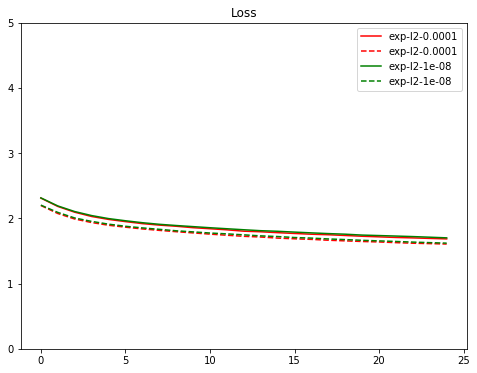

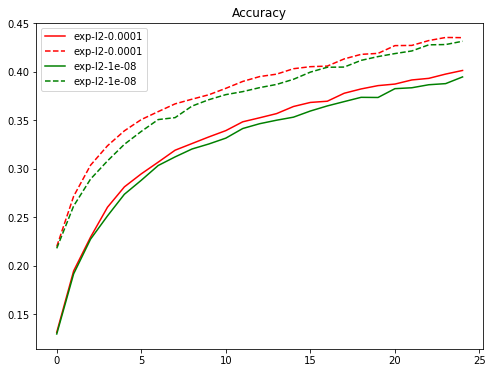

In [15]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results_1.keys()):
    plt.plot(range(len(results_1[cond]['train-loss'])),results_1[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_1[cond]['valid-loss'])),results_1[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results_1.keys()):
    plt.plot(range(len(results_1[cond]['train-acc'])),results_1[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_1[cond]['valid-acc'])),results_1[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()